In [88]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle

from keras import models
from keras.layers import Dense, Dropout


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


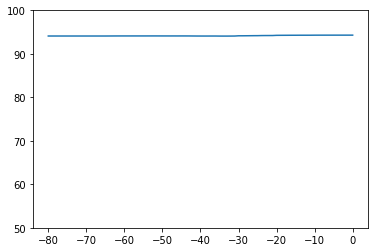

In [89]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Neural Network + linear regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

gtmax = gt.max()
ymax = y.max()
gt = gt/gtmax
y = y/ymax

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate
accuracies = []
r = 0
start = -80
window = 10
for train_i, test_i in lpo.split(y):
    r += 1
    X_train = []
    y_train = []

    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    for i in train_i:
        ship = ships[i]
        step = 1
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            features = [data[0][0]]#list(data[:, 0])
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            features.append(linear_pred)
            X_train.append(features)
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    # define model
    model = models.Sequential()
    model.add(Dense(64, activation='sigmoid', input_shape=(3,)))
    #model.add(Dense(24, activation='relu'))
    model.add(Dense(12, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train,
            batch_size=10,
            epochs=2000,
            verbose=0)

    #evaluate
    step = 1
    x = []
    acc_func = []
    sums = []
    for wk in range(start, 1, step):
        X_test = []
        y_test = []
        for i in test_i:
            ship = ships[i]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            features = [data[0][0]]#list(data[:, 0])
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            features.append(linear_pred)
            X_test.append(features)
            y_test.append(y[i])
        sums.append(current_sum)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        #get current progress
        cursor.execute(
            "SELECT"
            " sum(CASE WHEN wk <= {} THEN cables ELSE 0.0 END),"
            " sum(cast(cables as float))"
            " FROM progress WHERE project_id={}"
            .format(wk, ship)
        )
        progress = wk#cursor.fetchall()[0][0]

        preds = model.predict(X_test)
        #preds = linearModel.predict(X_test)
        y_true = y_test
        acc = 100*(1-mape(y_true, preds))
        x.append(progress)
        acc_func.append(acc)
    accuracies.append(acc_func)
    if r==2:
        break

accuracies = np.array(accuracies)
mean_acc_func = accuracies.mean(axis=0)
plt.plot(x, mean_acc_func)
plt.ylim([50, 100])
plt.show()
    
            